<a href="https://colab.research.google.com/github/FGalvao77/Analise-de-risco-para-concessao-de-credito/blob/main/An%C3%A1lise_de_risco_para_concess%C3%A3o_de_cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise de risco para concessão de crédito**

In [ ]:
# importando as bibliotecas
import pandas as pd
import numpy as np
from scipy import stats

import xgboost as xgb
import lightgbm as lgb  

from sklearn import metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# carregando o conjunto de dados de treino
train_data = pd.read_csv('https://raw.githubusercontent.com/FGalvao77/datasets/main/risco_credito/risco_credito_treino.csv')

In [ ]:
# visualizando as 5 primeiras linhas do conjunto de treino
train_data.head().T

,0,1,2,3,4
inadimplente,1.000000,0.000000,0.000000,0.00000,0.000000
util_linhas_inseguras,0.766127,0.957151,0.658180,0.23381,0.907239
idade,45.000000,40.000000,38.000000,30.00000,49.000000
vezes_passou_de_30_59_dias,2.000000,0.000000,1.000000,0.00000,1.000000
razao_debito,0.802982,0.121876,0.085113,0.03605,0.024926
salario_mensal,9120.000000,2600.000000,3042.000000,3300.00000,63588.000000
numero_linhas_crdto_aberto,13.000000,4.000000,2.000000,5.00000,7.000000
numero_vezes_passou_90_dias,0.000000,0.000000,1.000000,0.00000,0.000000
numero_emprestimos_imobiliarios,6.000000,0.000000,0.000000,0.00000,1.000000
numero_de_vezes_que_passou_60_89_dias,0.000000,0.000000,0.000000,0.00000,0.000000


In [ ]:
# visualizando a dimensão do conjunto de dados de treino
print(f'Tamanho do conjunto de dados de treino:\n- {train_data.shape[0]} linhas e, \n- {train_data.shape[1]} colunas.')

Tamanho do conjunto de dados de treino:
- 110000 linhas e, 
- 11 colunas.


In [ ]:
# visualizando as 3 primeiras linhas, 3 amostras aleatórias e as 3 últimas linhas do conjunto de treino
pd.concat([train_data.head(3),train_data.sample(3),train_data.tail(3)]).T

,0,1,2,60112,48015,102328,109997,109998,109999
inadimplente,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
util_linhas_inseguras,0.766127,0.957151,0.658180,0.033482,0.054169,0.013216,0.181257,0.037699,1.000000
idade,45.000000,40.000000,38.000000,38.000000,47.000000,33.000000,43.000000,86.000000,57.000000
vezes_passou_de_30_59_dias,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
razao_debito,0.802982,0.121876,0.085113,0.257214,0.314929,0.283716,0.382635,0.248107,0.002352
salario_mensal,9120.000000,2600.000000,3042.000000,4400.000000,11500.000000,1000.000000,12000.000000,7000.000000,3825.000000
numero_linhas_crdto_aberto,13.000000,4.000000,2.000000,8.000000,12.000000,16.000000,13.000000,14.000000,1.000000
numero_vezes_passou_90_dias,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
numero_emprestimos_imobiliarios,6.000000,0.000000,0.000000,1.000000,2.000000,0.000000,2.000000,2.000000,0.000000
numero_de_vezes_que_passou_60_89_dias,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# informações gerais do conjunto de dados de treino
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110000 entries, 0 to 109999
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   inadimplente                           110000 non-null  int64  
 1   util_linhas_inseguras                  110000 non-null  float64
 2   idade                                  110000 non-null  int64  
 3   vezes_passou_de_30_59_dias             110000 non-null  int64  
 4   razao_debito                           110000 non-null  float64
 5   salario_mensal                         88237 non-null   float64
 6   numero_linhas_crdto_aberto             110000 non-null  int64  
 7   numero_vezes_passou_90_dias            110000 non-null  int64  
 8   numero_emprestimos_imobiliarios        110000 non-null  int64  
 9   numero_de_vezes_que_passou_60_89_dias  110000 non-null  int64  
 10  numero_de_dependentes                  107122 non-null  

In [ ]:
# calculando a proporção de inadimplentes em relação aos adimplentes dos dados de treino
zero_count = train_data['inadimplente'][train_data['inadimplente'] == 0].count()
one_count = train_data['inadimplente'][train_data['inadimplente'] == 1].count()
proportion = zero_count/one_count

print(f'A proporção entre inadimplentes e adimplentes é de 1 : {int(proportion)}')

A proporção entre inadimplentes e adimplentes é de 1 : 14


In [ ]:
# carregando o conjunto de dados de teste
test_data = pd.read_csv('https://raw.githubusercontent.com/FGalvao77/datasets/main/risco_credito/risco_credito_teste.csv')

In [ ]:
# visualizando a dimensão do conjunto de dados de teste
print(f'Tamanho do conjunto de dados de teste:\n- {test_data.shape[0]} linhas e, \n- {test_data.shape[1]} colunas.')

Tamanho do conjunto de dados de teste:
- 40000 linhas e, 
- 10 colunas.


In [ ]:
# visualizando as 3 primeiras linhas, 3 amostras aleatórias e as 3 últimas linhas do conjunto de teste
pd.concat([test_data.head(3),test_data.sample(3),test_data.tail(3)]).T

,0,1,2,14409,10775,12636,39997,39998,39999
util_linhas_inseguras,0.025849,0.667083,0.007093,0.214060,0.406866,0.055542,0.817745,0.106139,1.000000
idade,62.000000,55.000000,44.000000,58.000000,55.000000,64.000000,70.000000,64.000000,28.000000
vezes_passou_de_30_59_dias,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
razao_debito,0.081775,0.153112,0.148800,0.055296,1672.000000,0.026097,0.663056,0.865438,0.002285
salario_mensal,8180.000000,2200.000000,7499.000000,1500.000000,NaN,1800.000000,6000.000000,5045.000000,3500.000000
numero_linhas_crdto_aberto,3.000000,3.000000,20.000000,2.000000,5.000000,8.000000,17.000000,12.000000,0.000000
numero_vezes_passou_90_dias,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
numero_emprestimos_imobiliarios,2.000000,0.000000,1.000000,0.000000,1.000000,0.000000,2.000000,4.000000,0.000000
numero_de_vezes_que_passou_60_89_dias,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
numero_de_dependentes,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
# estatística descritiva do conjunto de dados de treino
train_data.describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
inadimplente,110000.0,0.0666,0.2494,0.0,0.0000,0.0000,0.0000,1.0
util_linhas_inseguras,110000.0,5.9300,252.3020,0.0,0.0301,0.1559,0.5628,50708.0
idade,110000.0,52.2556,14.7682,0.0,41.0000,52.0000,63.0000,109.0
vezes_passou_de_30_59_dias,110000.0,0.4241,4.2408,0.0,0.0000,0.0000,0.0000,98.0
razao_debito,110000.0,354.8236,2074.1404,0.0,0.1750,0.3667,0.8669,329664.0
salario_mensal,88237.0,6637.4111,13383.9509,0.0,3400.0000,5400.0000,8225.0000,3008750.0
numero_linhas_crdto_aberto,110000.0,8.4456,5.1390,0.0,5.0000,8.0000,11.0000,58.0
numero_vezes_passou_90_dias,110000.0,0.2700,4.2173,0.0,0.0000,0.0000,0.0000,98.0
numero_emprestimos_imobiliarios,110000.0,1.0199,1.1360,0.0,0.0000,1.0000,2.0000,54.0
numero_de_vezes_que_passou_60_89_dias,110000.0,0.2439,4.2041,0.0,0.0000,0.0000,0.0000,98.0


In [ ]:
# estatística descritiva do conjunto de dados de teste
test_data.describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
util_linhas_inseguras,40000.0,6.3742,242.6172,0.0,0.0294,0.1495,0.5498,22000.0
idade,40000.0,52.4040,14.7815,21.0,41.0000,52.0000,63.0000,109.0
vezes_passou_de_30_59_dias,40000.0,0.4127,4.0579,0.0,0.0000,0.0000,0.0000,98.0
razao_debito,40000.0,348.0042,1934.4362,0.0,0.1754,0.3662,0.8723,307001.0
salario_mensal,32032.0,6760.6018,16836.3866,0.0,3400.0000,5409.5000,8284.0000,1794060.0
numero_linhas_crdto_aberto,40000.0,8.4725,5.1650,0.0,5.0000,8.0000,11.0000,57.0
numero_vezes_passou_90_dias,40000.0,0.2550,4.0343,0.0,0.0000,0.0000,0.0000,98.0
numero_emprestimos_imobiliarios,40000.0,1.0137,1.1125,0.0,0.0000,1.0000,2.0000,25.0
numero_de_vezes_que_passou_60_89_dias,40000.0,0.2308,4.0175,0.0,0.0000,0.0000,0.0000,98.0
numero_de_dependentes,38954.0,0.7565,1.1162,0.0,0.0000,0.0000,1.0000,13.0


In [ ]:
# visualizando as instâncias únicas da variável alvo
train_data['inadimplente'].unique()

array([1, 0])

In [ ]:
# distribuição relativa das instâncias da variável avo
train_data['inadimplente'].value_counts(normalize=True) * 100

0    93.335455
1     6.664545
Name: inadimplente, dtype: float64

> Os dados estão desbalanceados em relação ao valor alvo.

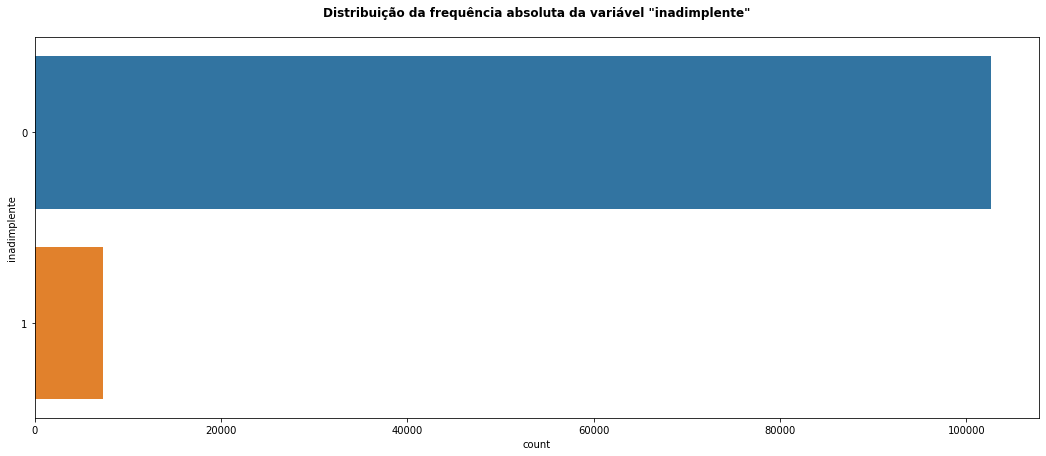

In [ ]:
# distribuição dos dados da variável alvo - inadimplente
plt.figure(figsize=(18, 7))
plt.title('Distribuição da frequência absoluta da variável "inadimplente"\n', 
         fontsize = 12, fontweight = 'bold')
sns.countplot(data=train_data, y='inadimplente');

In [ ]:
# contabilizando as instâncias únicas dos atributos do conjunto de dados de treino
train_data.nunique()

inadimplente                                 2
util_linhas_inseguras                    92671
idade                                       86
vezes_passou_de_30_59_dias                  15
razao_debito                             86002
salario_mensal                           12228
numero_linhas_crdto_aberto                  57
numero_vezes_passou_90_dias                 18
numero_emprestimos_imobiliarios             28
numero_de_vezes_que_passou_60_89_dias       13
numero_de_dependentes                       12
dtype: int64

In [ ]:
# contabilizando as instâncias únicas dos atributos do conjunto de dados de teste
test_data.nunique()

util_linhas_inseguras                    34211
idade                                       81
vezes_passou_de_30_59_dias                  14
razao_debito                             33800
salario_mensal                            7879
numero_linhas_crdto_aberto                  52
numero_vezes_passou_90_dias                 18
numero_emprestimos_imobiliarios             21
numero_de_vezes_que_passou_60_89_dias       10
numero_de_dependentes                       12
dtype: int64

In [ ]:
# contabilizando valores nulos/ausentes no conjunto de dados de treino
count = train_data.isnull().sum().sort_values(ascending = False)
percent = (train_data.isnull().sum()/train_data.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([count, percent], axis=1, keys=['Count', '%'])
missing_train_data.T.round(1).T

,Count,%
salario_mensal,21763.0,19.8
numero_de_dependentes,2878.0,2.6
numero_de_vezes_que_passou_60_89_dias,0.0,0.0
numero_emprestimos_imobiliarios,0.0,0.0
numero_vezes_passou_90_dias,0.0,0.0
numero_linhas_crdto_aberto,0.0,0.0
razao_debito,0.0,0.0
vezes_passou_de_30_59_dias,0.0,0.0
idade,0.0,0.0
util_linhas_inseguras,0.0,0.0


In [ ]:
# contabilizando valores nulos/ausentes no conjunto de dados de teste
count = test_data.isnull().sum().sort_values(ascending = False)
percent = (test_data.isnull().sum()/test_data.isnull().count()*100).sort_values(ascending = False)
missing_test_data  = pd.concat([count, percent], axis=1, keys=['Count', '%'])
missing_test_data.T.round(1).T

,Count,%
salario_mensal,7968.0,19.9
numero_de_dependentes,1046.0,2.6
numero_de_vezes_que_passou_60_89_dias,0.0,0.0
numero_emprestimos_imobiliarios,0.0,0.0
numero_vezes_passou_90_dias,0.0,0.0
numero_linhas_crdto_aberto,0.0,0.0
razao_debito,0.0,0.0
vezes_passou_de_30_59_dias,0.0,0.0
idade,0.0,0.0
util_linhas_inseguras,0.0,0.0


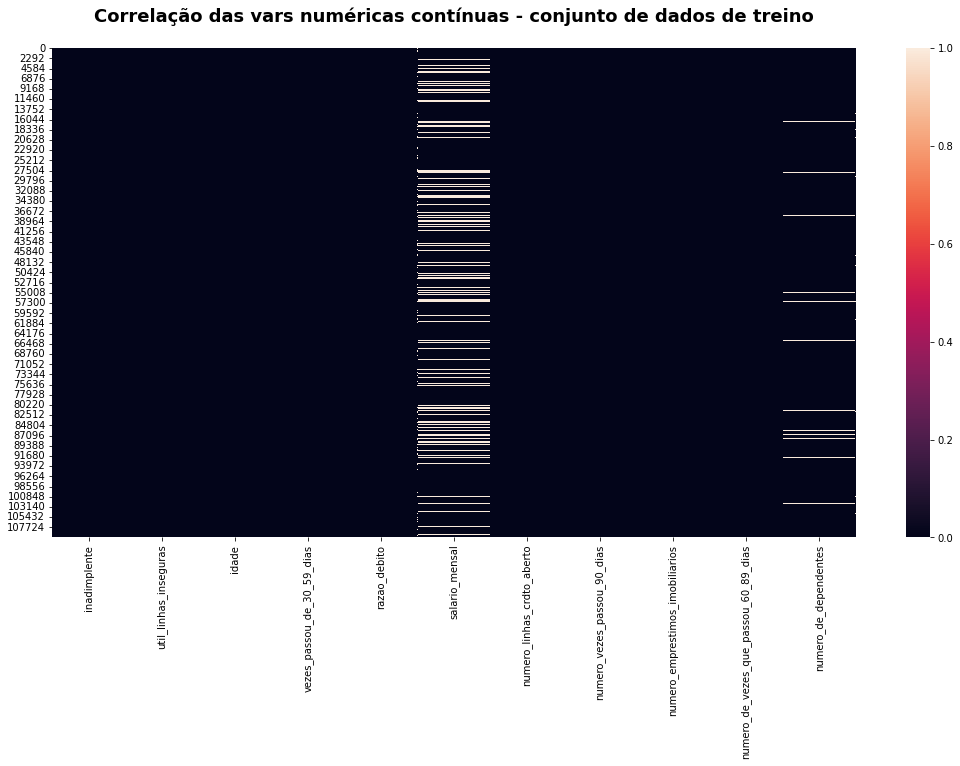

In [ ]:
# visualização gráfica da correlação das variáveis - dados de treino
plt.figure(figsize=(18, 9))
plt.title('Correlação das vars numéricas contínuas - conjunto de dados de treino\n', 
          {'fontsize': 18,'fontweight': 'bold'})
sns.heatmap(train_data.isnull());

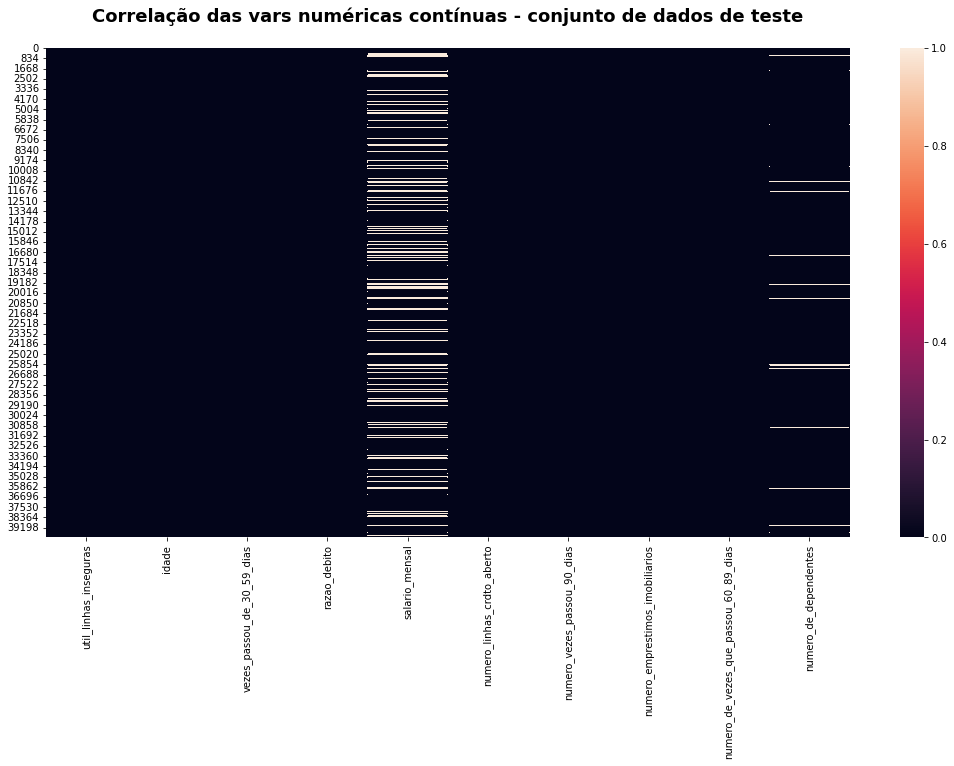

In [ ]:
# visualização gráfica da correlação das variáveis - dados de teste
plt.figure(figsize=(18, 9))
plt.title('Correlação das vars numéricas contínuas - conjunto de dados de teste\n', 
          {'fontsize': 18,'fontweight': 'bold'})
sns.heatmap(test_data.isnull());

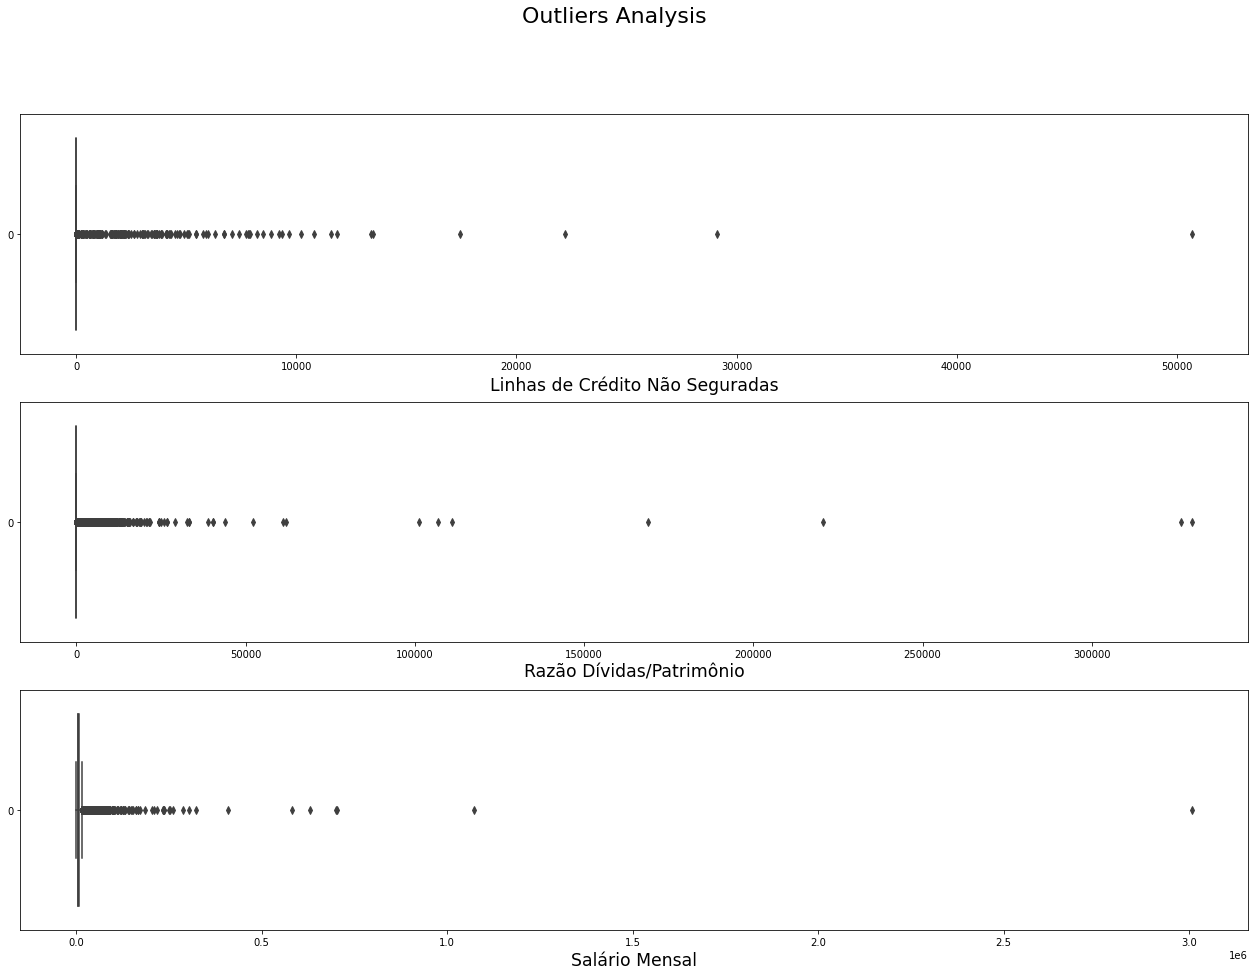

,util_linhas_inseguras,razao_debito,salario_mensal
Count,556.0,22902.0,3637.0
%,0.5,20.8,4.1


In [ ]:
# visualizando a presença de outliers
fig, axes = plt.subplots(3, 1, tight_layout=False, figsize=(22, 15))
fig.suptitle('Outliers Analysis\n', fontsize=22)
sns.boxplot(ax=axes[0], data=train_data['util_linhas_inseguras'], orient='h')
sns.boxplot(ax=axes[1], data=train_data['razao_debito'], orient='h')
sns.boxplot(ax=axes[2], data=train_data['salario_mensal'], orient='h')
axes[0].set_xlabel('Linhas de Crédito Não Seguradas', fontsize='xx-large')
axes[1].set_xlabel('Razão Dívidas/Patrimônio', fontsize='xx-large')
axes[2].set_xlabel('Salário Mensal', fontsize='xx-large')
plt.show()

Q1 = train_data[['util_linhas_inseguras','razao_debito','salario_mensal']].quantile(0.25)
Q3 = train_data[['util_linhas_inseguras','razao_debito','salario_mensal']].quantile(0.75)
IQR = Q3 - Q1

n_outliers = ((train_data[['util_linhas_inseguras','razao_debito','salario_mensal']] < (Q1 - 1.5 * IQR)) | (
               train_data[['util_linhas_inseguras','razao_debito','salario_mensal']] > (Q3 + 1.5 * IQR))).sum()
percent_outliers = n_outliers/train_data[['util_linhas_inseguras','razao_debito','salario_mensal']].count()*100
pd.concat([n_outliers, percent_outliers], axis=1, keys=['Count', '%']).T.round(1)

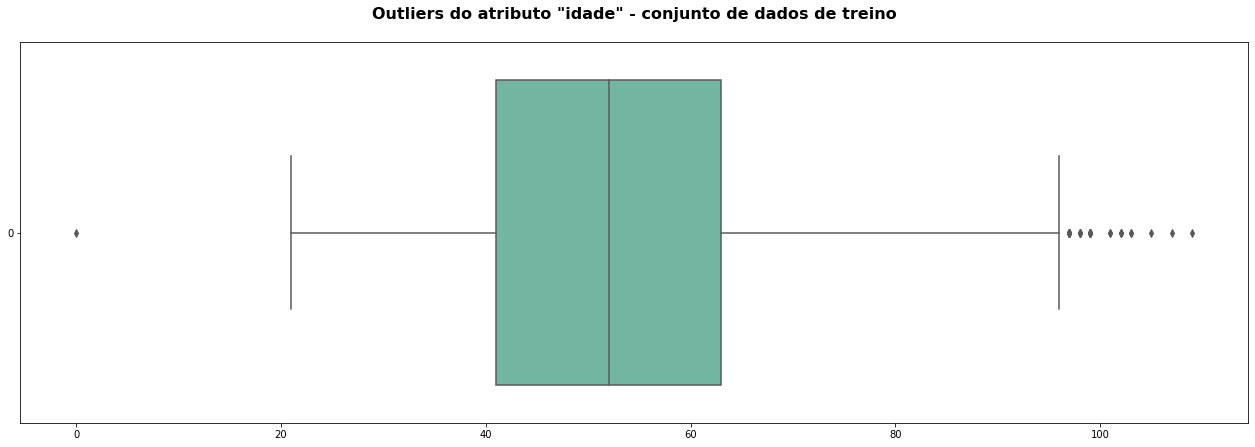

In [ ]:
# visualizando a presença de "outliers" no atributo idade do conjunto de dados de treino
plt.figure(figsize=(22, 7))
plt.title('Outliers do atributo "idade" - conjunto de dados de treino\n', 
          {'fontsize': 16,'fontweight': 'bold'})
sns.boxplot(data = train_data['idade'], orient = 'h', palette = 'Set2');

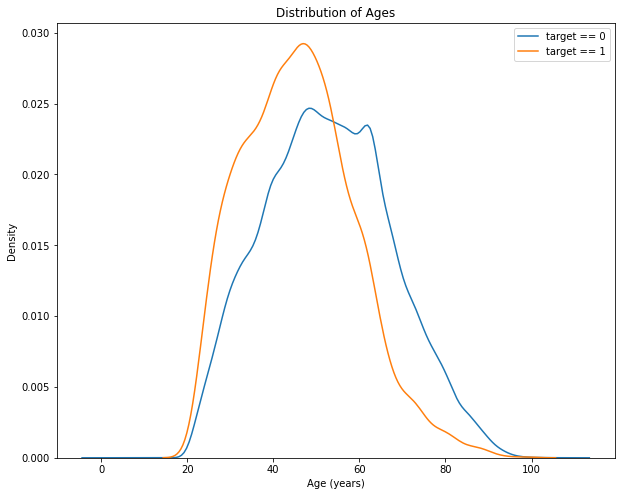

In [ ]:
plt.figure(figsize = (10, 8))

# empréstimos que foram pagos dentro do prazo
sns.kdeplot(train_data.loc[train_data['inadimplente'] == 0, 'idade'], label = 'target == 0')

# empréstimos que não foram pagos a tempo
sns.kdeplot(train_data.loc[train_data['inadimplente'] == 1, 'idade'], label = 'target == 1')

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages')
plt.legend();

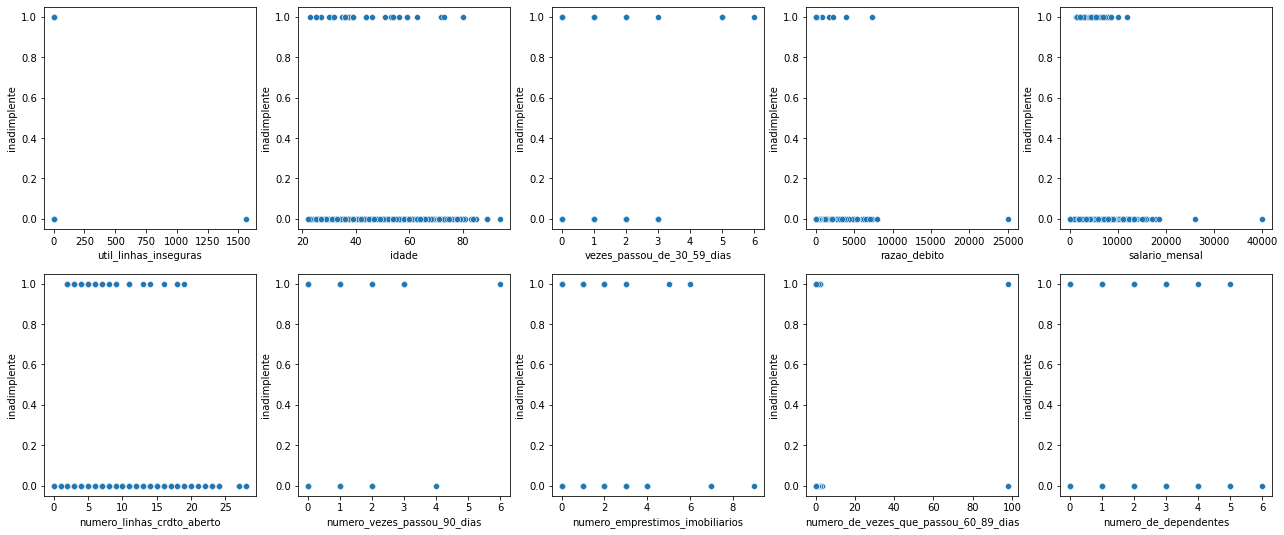

In [ ]:
# visualizando a distribuição dos atributos em relação a variável alvo - inadimplentes
fig, axes = plt.subplots(2, 5, figsize=(22, 9), tight_layout=False)

for i in range(2):
    for j in range(5):
        sns.scatterplot(ax=axes[i,j],
                        data=train_data,x=train_data.iloc[:,(5*i+j+1)].sample(500), 
                        y=train_data.iloc[:,0])

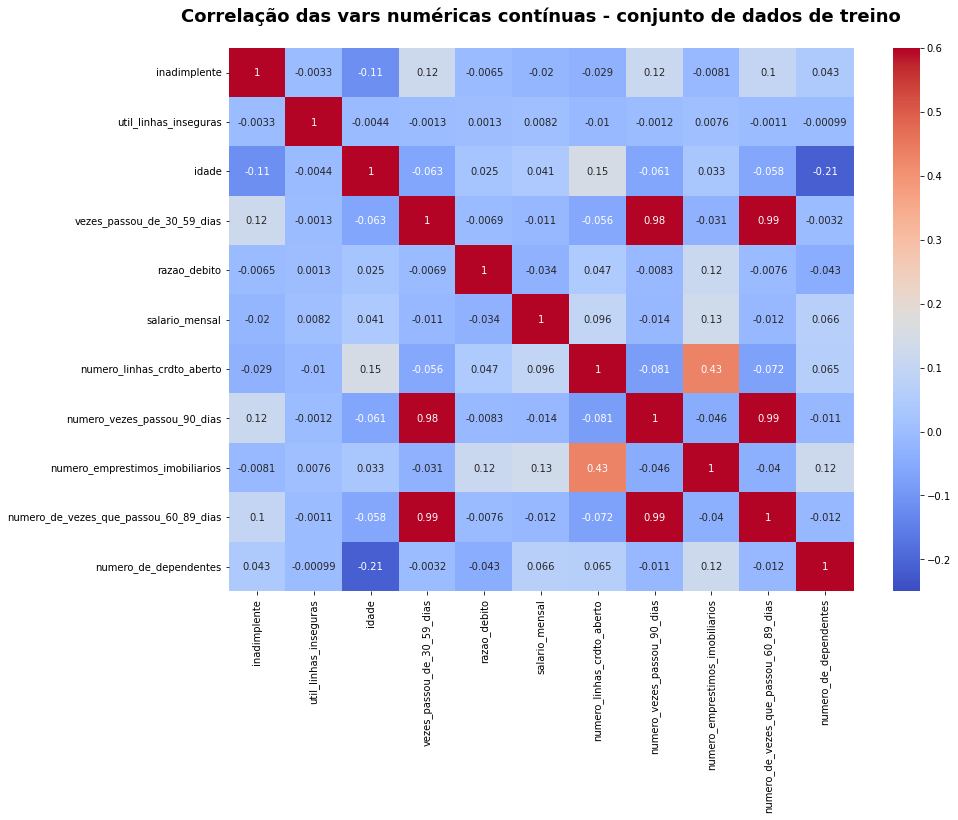

In [ ]:
# correlação das variáveis numéricas  do conjunto de dados de treino
corr_train = train_data.corr()

plt.figure(figsize = (14, 10))
sns.heatmap(corr_train, cmap = 'coolwarm', vmin = -0.25, 
            annot = True, vmax = 0.6)
plt.title('Correlação das vars numéricas contínuas - conjunto de dados de treino\n', 
          {'fontsize': 18,'fontweight': 'bold'});

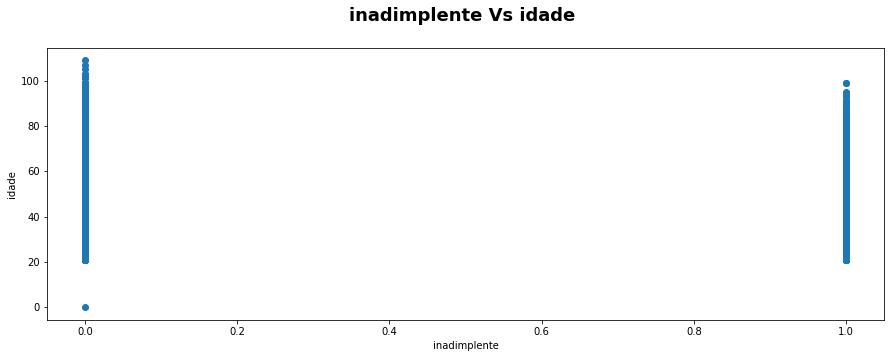

In [ ]:
# gráfico inadimplente Vs idade
plt.figure(figsize=(15, 5))
plt.scatter(train_data['inadimplente'], train_data['idade'])
plt.xlabel('inadimplente')
plt.ylabel('idade')
plt.title('inadimplente Vs idade \n',
           {'fontsize': 18,'fontweight': 'bold'});

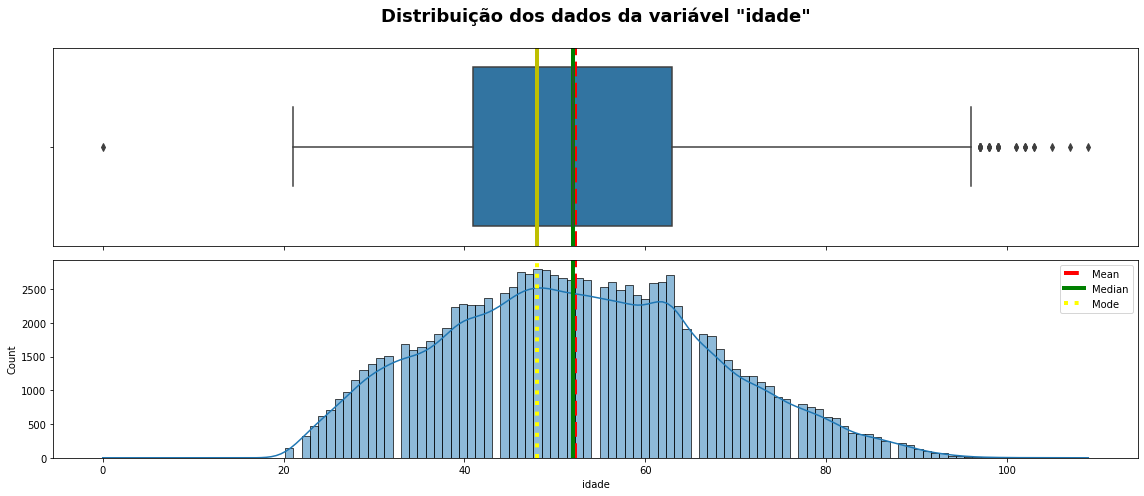

In [ ]:
# plotando gráficos - boxplot e histograma da distribuição dos dados da variável "idade"
mean = train_data['idade'].mean()
median = train_data['idade'].median()
mode = train_data['idade'].mode()[0]

fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                      figsize = (16, 7))

sns.boxplot(data=train_data, x='idade', ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--', linewidth=4)
ax_box.axvline(median, color='g', linestyle='-', linewidth=4)
ax_box.axvline(mode, color='y', linestyle='-', linewidth=4)
ax_box.set(xlabel='')
ax_box.set_title('Distribuição dos dados da variável "idade"\n',
                 {'fontsize': 18,'fontweight': 'bold'})

sns.histplot(data=train_data, x='idade', ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='red', linestyle='--', label='Mean', linewidth=4)
ax_hist.axvline(median, color='green', linestyle='-', label='Median', linewidth=4)
ax_hist.axvline(mode, color='yellow', linestyle=':', label='Mode', linewidth=4)

ax_hist.legend()
plt.tight_layout();

In [ ]:
# instanciando as variáveis explicativas (X) e a resposta (y)
X = train_data.iloc[:, 1:]
y = train_data.iloc[:, 0]

# particionando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=1, 
                                                    test_size=0.2)

In [ ]:
# aplicando o primeiro modelo
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric= 'aucpr', 
                          base_score=(1-1/proportion), 
                          scale_pos_weight=proportion)

model.fit(X_train, y_train)

predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# expected = y_test

print('Extreme Gradient Boosting Model Metrics:\n')
print(metrics.classification_report(y_test, predicted))
print('\n Confusion Matrix:\n [[TP       FN]\n [FP       TN]]\n', metrics.confusion_matrix(y_test, predicted))
print('\nProbability:\n', probs[:,1])

Extreme Gradient Boosting Model Metrics:

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     20554
           1       0.21      0.76      0.33      1446

    accuracy                           0.80     22000
   macro avg       0.60      0.78      0.61     22000
weighted avg       0.93      0.80      0.85     22000


 Confusion Matrix:
 [[TP       FN]
 [FP       TN]]
 [[16498  4056]
 [  347  1099]]

Probability:
 [0.14654893 0.11283872 0.32241    ... 0.8270771  0.2876551  0.1536048 ]


In [ ]:
# aplicando o segundo modelo
model = xgb.XGBClassifier(eval_metric= 'aucpr', use_label_encoder=False,
                          base_score=(1-1/proportion), 
                          scale_pos_weight=proportion, 
                          eta=0.02, alpha=100)

model.fit(X_train, y_train)

predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# expected = y_test

print("Extreme Gradient Boosting Model Metrics:\n")
print(metrics.classification_report(y_test, predicted))
print("\n Confusion Matrix:\n [[TP       FN]\n [FP       TN]]\n", metrics.confusion_matrix(y_test, predicted))
print("\nProbability:\n", probs[:,1])

Extreme Gradient Boosting Model Metrics:

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     20554
           1       0.21      0.76      0.33      1446

    accuracy                           0.80     22000
   macro avg       0.60      0.78      0.61     22000
weighted avg       0.93      0.80      0.85     22000


 Confusion Matrix:
 [[TP       FN]
 [FP       TN]]
 [[16498  4056]
 [  347  1099]]

Probability:
 [0.14654893 0.11283872 0.32241    ... 0.8270771  0.2876551  0.1536048 ]


In [ ]:
# realizando as predições com os dados de teste
predicted = model.predict(test_data)
probs = model.predict_proba(test_data)[:,1]*100

# salvando as predições e as probabilidades 
output = {'inadimplente': predicted, 'probabilidade %': probs}
output = pd.DataFrame(data=output)
output.to_csv('output.csv',index=False)

# criando um arquivo dataframe
predicted = pd.DataFrame({'inadimplente': predicted})

# salvando o arquivo para submissão
Submission_File = predicted.join(test_data)
Submission_File.to_csv('Submission_File.csv',index=False)

In [ ]:
# visualizando o arquivo com as probabilidades de cada instância real
output

,inadimplente,probabilidade %
0,0,6.583509
1,0,39.690105
2,0,13.749557
3,1,55.609894
4,0,18.113165
...,...,...
39995,1,73.997513
39996,0,8.116012
39997,1,53.883671
39998,1,71.550026


In [ ]:
# concatenando as bases de dados
df = train_data.append(test_data, ignore_index=True)

df

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1.0,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0.0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0.0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0.0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0.0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149995,NaN,0.000000,68,1,0.062858,10833.0,9,1,0,0,0.0
149996,NaN,0.061117,84,0,0.013598,8456.0,7,0,0,0,0.0
149997,NaN,0.817745,70,0,0.663056,6000.0,17,0,2,0,0.0
149998,NaN,0.106139,64,2,0.865438,5045.0,12,0,4,0,0.0


In [ ]:
# contabiblizando valores nulos e/ou faltantes do conjunto de dados
df.isnull().sum()

inadimplente                             40000
util_linhas_inseguras                        0
idade                                        0
vezes_passou_de_30_59_dias                   0
razao_debito                                 0
salario_mensal                           29731
numero_linhas_crdto_aberto                   0
numero_vezes_passou_90_dias                  0
numero_emprestimos_imobiliarios              0
numero_de_vezes_que_passou_60_89_dias        0
numero_de_dependentes                     3924
dtype: int64

In [ ]:
df[['salario_mensal', 'numero_de_dependentes']].describe().T

,count,mean,std,min,25%,50%,75%,max
salario_mensal,120269.0,6670.221237,14384.674215,0.0,3400.0,5400.0,8249.0,3008750.0
numero_de_dependentes,146076.0,0.757222,1.115086,0.0,0.0,0.0,1.0,20.0


In [ ]:
# contabilizando a presença de dados duplicados
df.duplicated().sum()

434

In [ ]:
# removendo dados duplicados
df.drop_duplicates(keep=False, inplace=True)

In [ ]:
# contabilizando a presença de dados duplicados apoś o tratamento
df.duplicated().sum()

0

In [ ]:
df[['salario_mensal', 'numero_de_dependentes']].describe().T

,count,mean,std,min,25%,50%,75%,max
salario_mensal,120150.0,6676.083154,14390.571719,0.0,3400.0,5400.0,8250.0,3008750.0
numero_de_dependentes,145473.0,0.760320,1.116324,0.0,0.0,0.0,1.0,20.0


In [ ]:
df[['salario_mensal', 'numero_de_dependentes']].dtypes

salario_mensal           float64
numero_de_dependentes    float64
dtype: object

In [ ]:
# # aplicando o preenchimento com a moda
# df.fillna(df.mode()[0], inplace=True)

In [ ]:
# # contabiblizando valores nulos e/ou faltantes do conjunto de dados
# df.isnull().sum()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149279 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   inadimplente                           109405 non-null  float64
 1   util_linhas_inseguras                  149279 non-null  float64
 2   idade                                  149279 non-null  int64  
 3   vezes_passou_de_30_59_dias             149279 non-null  int64  
 4   razao_debito                           149279 non-null  float64
 5   salario_mensal                         120150 non-null  float64
 6   numero_linhas_crdto_aberto             149279 non-null  int64  
 7   numero_vezes_passou_90_dias            149279 non-null  int64  
 8   numero_emprestimos_imobiliarios        149279 non-null  int64  
 9   numero_de_vezes_que_passou_60_89_dias  149279 non-null  int64  
 10  numero_de_dependentes                  145473 non-null  

In [ ]:
# criando uma função para separar as colunas numéricas e categóricas do conjunto de dados
df_copy = df.copy()     # criando uma cópia da base de dados

def separate_cols(df):
    cols_cats = []
    cols_nums = []

    for col in df.columns:     # excluindo a último coluna - o alvo
    # for col in df.drop('Downloads'):
        if df.dtypes[col] == 'object':
            cols_cats.append(col)
        else:
            cols_nums.append(col)
    
    return f'cols categ: {len(cols_cats), cols_cats}', f'cols nums: {len(cols_nums), cols_nums}'

In [ ]:
# aplicando a função no df_copy
separate_cols(df_copy)

('cols categ: (0, [])',
 "cols nums: (11, ['inadimplente', 'util_linhas_inseguras', 'idade', 'vezes_passou_de_30_59_dias', 'razao_debito', 'salario_mensal', 'numero_linhas_crdto_aberto', 'numero_vezes_passou_90_dias', 'numero_emprestimos_imobiliarios', 'numero_de_vezes_que_passou_60_89_dias', 'numero_de_dependentes'])")

In [ ]:
# instanciando as bases de dados de treino e teste
df_train = df[df['inadimplente'].isnull() == False]
df_test = df[df['inadimplente'].isnull() == True]

# deletando o atributo "Downloads" da base de dados de teste
del df_test['inadimplente']

In [ ]:
df_train.shape, df_test.shape

((109405, 11), (39874, 10))

In [ ]:
# separando as variáveis explicativas (X) e a resposta (y)
X = df_train.drop(labels=['inadimplente'], axis=1)
y = df_train['inadimplente'].values

In [ ]:
# # aplicando o preenchimento com a moda
# y.fillna(y.mode()[0], inplace=True)

In [ ]:
# importando a biblioteca para realizar o particionamento dos dados em treino e validação do modelo
from sklearn.model_selection import train_test_split

# aplicando a divisão dos dados em treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.3,
                                                  random_state=101, 
                                                  stratify=y)

In [ ]:
# visualizando a dimensão das bases de dados - treino e validação
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((76583, 10), (32822, 10), (76583,), (32822,))

In [ ]:
# instanciando o objeto "df_train", para isso utilizamos a função ".DMatrix" do XGBoost
# e passando como argumentos os dados de treino "df_train" e os seus rótulos "y_train"
df_train = xgb.DMatrix(X_train, label=y_train)

# instanciando o objeto "df_test", para isso utilizamos a função ".DMatrix" do XGBoost
df_test = xgb.DMatrix(X_val)

In [ ]:
# instanciando um dicionário com os parâmetros do segundo modelo
params_xgb = {
    'n_estimators': 1300,
    'max_depth': 6,
    'min_child_weight': 4,
    'subsample': 0.9,
    'colsample_bynode': 0.5,
    'random_state': 42, 
    'num_parallel_tree': 3,
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr', 
    'learning_rate': 0.5 
}                            

In [ ]:
# definindo o número de treinamento
num_round = 150

# importando a função para contabilizar o tempo de treinbamento do modelo
from datetime import datetime
start = datetime.now()

# treinando o primeiro modelo
model_xgb = xgb.train(params_xgb, df_train, num_round)
stop = datetime.now()

# visualizando o seu tempo de execução
execution_time_xgb = stop - start
execution_time_xgb

datetime.timedelta(seconds=22, microseconds=508393)

In [ ]:
# realizando as predições
y_pred_xgb = model_xgb.predict(df_test)

# tamanho das predições realizadas
y_pred_xgb.size

32822

In [ ]:
# visualizando as 10 primeiras predições
y_pred_xgb[:10]

array([0.02876811, 0.05456643, 0.00937734, 0.41526628, 0.00409489,
       0.00467735, 0.00281006, 0.00198778, 0.08583896, 0.00295131],
      dtype=float32)

In [ ]:
# realizando um "for" para definir o "corte" das probabilidades realizadas pelo modelo
# e instanciando as classes
for i in range(0, len(y_pred_xgb)):
    if y_pred_xgb[i] >= 0.75:
        y_pred_xgb[i] = 1
    else:
        y_pred_xgb[i] = 0

In [ ]:
# importando a biblioteca para avaliação do modelo
from sklearn.metrics import accuracy_score

In [ ]:
# realizando avaliação do modelo
acc_model_xgb = accuracy_score(y_pred_xgb, y_val)
acc_model_xgb

0.9352263725549936

In [ ]:
# aplicando o segundo modelo com dados após o tratamento
model = xgb.XGBClassifier(eval_metric= 'aucpr', use_label_encoder=False,
                          base_score=(1-1/proportion), 
                          scale_pos_weight=proportion, 
                          eta=0.02, alpha=100)

model.fit(X_train, y_train)

predicted = model.predict(X_val)
probs = model.predict_proba(X_val)

# expected = y_val

print("Extreme Gradient Boosting Model Metrics:\n")
print(metrics.classification_report(y_val, predicted))
print("\n Confusion Matrix:\n [[TP       FN]\n [FP       TN]]\n", metrics.confusion_matrix(y_val, predicted))
print("\nProbability:\n", probs[:,1])

Extreme Gradient Boosting Model Metrics:

              precision    recall  f1-score   support

         0.0       0.98      0.79      0.88     30630
         1.0       0.21      0.79      0.33      2192

    accuracy                           0.79     32822
   macro avg       0.60      0.79      0.60     32822
weighted avg       0.93      0.79      0.84     32822


 Confusion Matrix:
 [[TP       FN]
 [FP       TN]]
 [[24186  6444]
 [  457  1735]]

Probability:
 [0.29558885 0.5231311  0.09381548 ... 0.47268167 0.11802781 0.07082993]


              precision    recall  f1-score   support

         0.0       0.98      0.79      0.88     30630
         1.0       0.21      0.79      0.33      2192

    accuracy                           0.79     32822
   macro avg       0.60      0.79      0.60     32822
weighted avg       0.93      0.79      0.84     32822



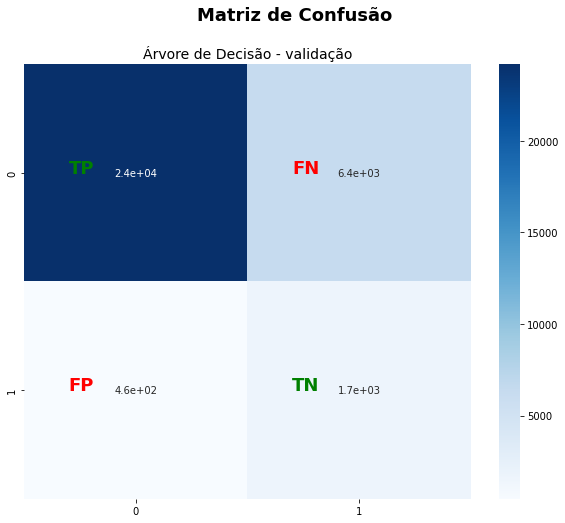

In [ ]:
# imprimindo o relatório de classificação dos dados de validação do modelo
print(metrics.classification_report(y_val, predicted))

# visualizando graficamente a matriz de confusão dos dados de validação do modelo
fig = plt.figure(figsize=[10, 8])
fig.suptitle('Matriz de Confusão', fontsize=18, fontweight='bold')

sns.heatmap(metrics.confusion_matrix(y_val, predicted), cmap='Blues', annot=True)
plt.title('Árvore de Decisão - validação', fontsize=14)
plt.xticks()
plt.yticks()

plt.annotate('TP', (0.2,0.5), fontsize=18, fontweight='bold', color='green')
plt.annotate('FN', (1.2,0.5), fontsize=18, fontweight='bold', color='red')
plt.annotate('FP', (0.2,1.5), fontsize=18, fontweight='bold', color='red')
plt.annotate('TN', (1.2,1.5), fontsize=18, fontweight='bold', color='green')

plt.show();

In [ ]:
predicted = model.predict(test_data)
probs = model.predict_proba(test_data)[:,1]*100

output = {'inadimplente': predicted, 'probabilidade %': probs}
output = pd.DataFrame(data=output)
output.to_csv('output.csv',index=False)

predicted = pd.DataFrame({'inadimplente': predicted})

Submission_File = predicted.join(test_data)
Submission_File.to_csv('Submission_File.csv',index=False)

output

,inadimplente,probabilidade %
0,0.0,7.249581
1,0.0,39.889847
2,0.0,20.078035
3,1.0,53.541069
4,0.0,14.444592
...,...,...
39995,1.0,74.072197
39996,0.0,7.124867
39997,0.0,49.381870
39998,1.0,77.168053
